In [1]:
# import pynninterp

import numpy as np

import matplotlib.pyplot as plt
from resonance import plotting
from resonance.neuralnodes import utils

from resonance.rebound_inh.model import run_model
from resonance.rebound_inh.params import Params



plt.style.use('ncb.mplstyle')

## Generate model outputs

### Stimulus

#### Response

In [ ]:
stim_step = .1
fs = 10_000.0
max_len = 20
input_stim, s, paui, duri = utils.makePPFstim(ppauMax=max_len, pdurMax=max_len, cdur=200, cpau=0, Fs=fs, step=stim_step)
new_points = np.array([s['ppau'], s['pdur']]).T / fs * 1000
paui = paui / fs * 1000
duri = duri / fs * 1000
params = Params.from_yaml('params/rebound_inh_params.yaml')

outs = run_model(input_stim,params, fs,verbose_output = True)

ppf = np.nanmean(outs[-1][250:-100], axis=0)

ppf = ppf.reshape((len(duri), len(paui)))


<Figure size 1000x1000 with 0 Axes>

/var/folders/lz/h0pd23610q36ss5zm1x9kfn0gy02sm/T/ipykernel_92821/2861134649.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


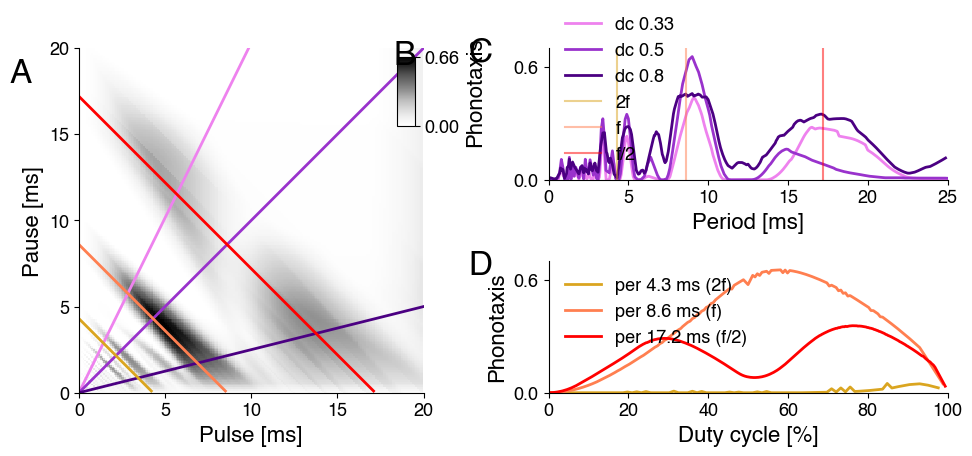

In [3]:
# fig, axs = plt.subplots(nrows=3, ncols=1, height_ratios=[2, 0.8, 0.8],figsize=(5, 10) )
axs = [None, None, None]
plt.figure(figsize=(15, 4.5))
axs[0] = plt.subplot(131)
plotting.ppf(duri, paui, ppf, ax=axs[0])

axs[1] = plt.subplot(232)
axs[2] = plt.subplot(235)

col_dc = ['violet', 'darkorchid', 'indigo']
col_per = ['goldenrod', 'coral', 'red']

dcs = [0.33, 0.5, 0.8]
pers = [4.3, 8.6, 17.2]
# period transects
plt.sca(axs[1])
for dc, col in zip(dcs, col_dc):
    dur = np.arange(0, max_len+0.1, 0.01)
    pau = dur / dc - dur
    dur = dur[pau <= max_len]
    pau = pau[pau <= max_len]
    axs[0].plot(dur, pau, c=col, linewidth=2)
    plt.plot(pau+dur, plotting.transect(new_points, ppf, dur, pau, grid=False), c=col, label=f'dc {dc}', linewidth=2.0)
plt.xlabel('Period [ms]')
for f, c, l in zip(pers, col_per, ['2f', 'f', 'f/2']):
    plt.axvline(f, c=c, alpha=0.5, label=l)
plt.xlim(0, 25)
plt.ylim(0, 0.7)
plt.yticks([0, 0.6])
plt.legend(frameon=False)

# DC transects
plt.sca(axs[2])
per = 10
for per, frq, col in zip(pers, ['2f', 'f', 'f/2'], col_per):
    pau = np.arange(0.1, per, 0.01)
    dur = per - pau
    dc = dur / per
    dur = dur[pau <= max_len]
    pau = pau[pau <= max_len]
    axs[0].plot(dur, pau, c=col, linewidth=2)
    plt.plot(dc * 100, plotting.transect(new_points, ppf, dur, pau, grid=False), c=col, label=f'per {per} ms ({frq})', linewidth=2.0)
plt.xlabel('Duty cycle [%]')
plt.ylabel('Phonotaxis')
# for d, c, l in zip(dcs, col_dc, dcs):
#     plt.axvline(d * 100, c=c, alpha=0.5, label=l)
plt.xlim(0, 100)
plt.ylim(0, 0.7)
plt.yticks([0, 0.6])
plt.legend(frameon=False)


plotting.label_axes()
plt.tight_layout()

plt.savefig(f'fig/Fig_rebound_inh_2.pdf')

In [ ]:
def plot_norm(sig):
    return sig/(np.max(np.abs(sig)))

stim_step = 1
fs = 4_000.0
max_len = 20
input_stim, s, paui, duri = utils.makePPFstim(ppauMax=max_len, pdurMax=max_len, cdur=200, cpau=0, Fs=fs, step=stim_step)
new_points = np.array([s['ppau'], s['pdur']]).T / fs * 1000
paui = paui / fs * 1000
duri = duri / fs * 1000
params = Params.from_yaml('params/rebound_inh_params.yaml')

outs = run_model(input_stim,params, fs,verbose_output = True)
ppf_out = np.nanmean(outs[-1][250:-100], axis=0)
ppf_inhib = np.nanmean(outs[-2][250:-100], axis=0)
ppf_reb = np.nanmean(outs[-4][250:-100], axis=0)



pau1 = np.arange(0,20.0, 1)
dur1 = np.arange(0,20.0,1)
ppau1d=np.repeat(pau1,np.size(dur1))
pdur1d=np.tile(dur1,np.size(pau1))

xpdur = np.array(pdur1d)
yppau = np.array(ppau1d)
ppers = np.zeros(np.size(xpdur))
pdcs = np.zeros(np.size(xpdur))
for i in range(np.size(xpdur)):
    ppers[i]=((yppau[i]+xpdur[i]))
    pdcs[i] = xpdur[i]*10 / (ppers[i])

xi0 = np.arange(0, 25.0, .1)
yi0 = np.arange(0, 10.0, .05)
xi,yi = np.meshgrid(xi0,yi0)
zicalc_out = np.nan_to_num(pynninterp.NaturalNeighbour(ppers, np.nan_to_num(pdcs), np.asarray(ppf_out).astype(float), xi, yi))
zicalc_inhib = np.nan_to_num(pynninterp.NaturalNeighbour(ppers, np.nan_to_num(pdcs), np.asarray(ppf_inhib).astype(float), xi, yi))
zicalc_reb = np.nan_to_num(pynninterp.NaturalNeighbour(ppers, np.nan_to_num(pdcs), np.asarray(ppf_reb).astype(float), xi, yi))


# plt.subplots_adjust(hspace=0.4,wspace=.2)

# fig = plt.figure(figsize=(10, 3))
plt.figure(figsize=(15, 4.5))
plt.subplot(232)
pdci = np.linspace(0,1,200, endpoint=True) * 100

plt.plot(pdci, plot_norm(np.mean(zicalc_reb[:,170:180],axis=1)), linewidth=2.0,color='Darkgrey',label='Exc to LN4')
plt.plot(pdci, -plot_norm(np.mean(zicalc_inhib[:,170:180],axis=1)), linewidth=2.0,color='slateblue',label='Inh to LN4')
plt.plot(pdci, plot_norm(np.mean(zicalc_out[:,170:180],axis=1)), linewidth=2.0,color='green',label='Model response')


plt.ylabel('Norm. response')
plt.xlabel('Duty cycle [%]')
plt.title('DC tuning at 2 Ts')
plt.ylim(0, 1.1)
plt.yticks([0, 1])
plt.legend(frameon=False)

plt.savefig(f'fig/Fig_rebound_inh.pdf')
plt.show()

/var/folders/lz/h0pd23610q36ss5zm1x9kfn0gy02sm/T/ipykernel_92821/3243568747.py:31: RuntimeWarning: invalid value encountered in scalar divide
  pdcs[i] = xpdur[i]*10 / (ppers[i])


NameError: name 'pynninterp' is not defined

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


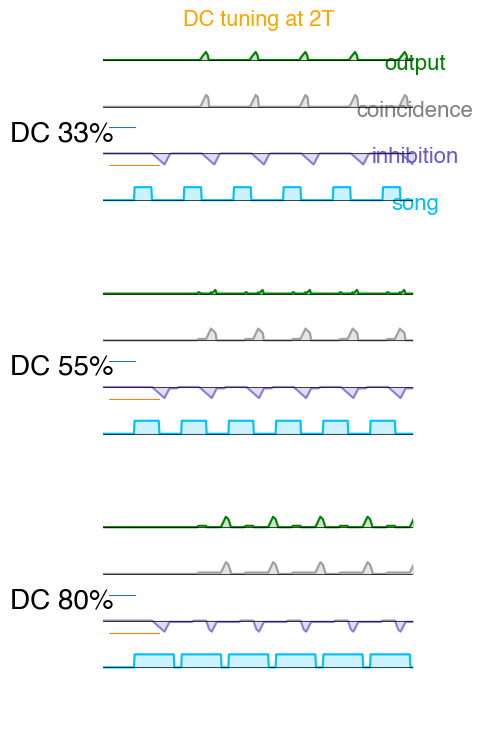

In [ ]:
stim_step = 1
fs = 4_000.0
max_len = 20

input_stim, s, paui, duri = utils.makePPFstim(ppauMax=max_len, pdurMax=max_len, cdur=200, cpau=0, Fs=fs, step=stim_step)
new_points = np.array([s['ppau'], s['pdur']]).T / fs * 1000
paui = paui / fs * 1000
duri = duri / fs * 1000

out = run_model(input_stim, params,verbose_output = True)
fig, axs = plt.subplots(15,1,figsize=(4,9),sharex='col',sharey='col')
labels=['33','55','80']
#(sub_output_linear (an1), sub_output (an1nonlin), ln3_output, ln2_output, ln2_ln4_output, output, p)
def make_axs_plt(idx,num,out):
    #axs[ax1,ax2].set_prop_cycle(custom_cycler)
    sub_output=out[-4][:500,idx]
    ln2_ln4_out=out[-2][:500,idx]
    output=out[-1][:500,idx]
    stim = input_stim[:500,idx]

    x=np.arange(len(sub_output))

    axs[num+0].plot(output,linewidth=1.5,color='green',alpha=1,label='out')
    axs[num+0].fill_between(x,0,output.flatten(), interpolate=True, color='green',alpha=.2)
    axs[num+0].axhline(c='k', linewidth=0.5)
    axs[num+2].plot(ln2_ln4_out,linewidth=1.5,color='slateblue',alpha=.7,label='ln2_ln4_out')
    axs[num+2].fill_between(x,0,ln2_ln4_out.flatten(), interpolate=True, color='slateblue',alpha=.2)
    axs[num+2].axhline(c='k', linewidth=0.5)
    axs2 = axs[num+2].twinx()
    axs2.set_ylabel(f'DC {labels[int(num/5)]}%',rotation='horizontal',fontsize=20,labelpad=30,color='k')
    axs2.yaxis.set_label_position("left")
    axs2.spines['top'].set_visible(False)
    axs2.spines['right'].set_visible(False)
    axs2.spines['bottom'].set_visible(False)
    axs2.spines['left'].set_visible(False)
    axs2.get_xaxis().set_ticks([])
    axs2.get_yaxis().set_ticks([])
    axs[num+1].plot(sub_output,linewidth=1.5,color='grey',alpha=.7,label='ln3')
    axs[num+1].fill_between(x,0,sub_output.flatten(), interpolate=True, color='grey',alpha=.2)
    axs[num+1].axhline(c='k', linewidth=0.5)
    axs[num+3].plot(stim,linewidth=1.5,label='Incoming Song',color='deepskyblue')
    axs[num+3].fill_between(x,0,stim.flatten(), interpolate=True, color='deepskyblue',alpha=.2)
    axs[num+3].axhline(c='k', linewidth=0.5)
    axs[num+3].set_ylim([-1, 2])
    plt.plot([10, 50], [0.5, 0.5])
    plt.plot([10, 90], [0.4, 0.4])

    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

idx=267 # dur 5 pau 14
make_axs_plt(idx,0,out)
# plotting.scalebar(4000 / 1000, units='ms')

axs[3].set_ylabel('song',rotation='horizontal', labelpad=1,color='deepskyblue')
axs[2].set_ylabel('inhibition',rotation='horizontal', labelpad=1,color='slateblue')
axs[1].set_ylabel('coincidence',rotation='horizontal', labelpad=1,color='grey')
axs[0].set_ylabel('output',rotation='horizontal', labelpad=1,color='green')
axs[0].set_title('DC tuning at 2T',rotation='horizontal', color='orange')

for ax in axs:
    # ax.set(xlim=(0, 500))
    ax.yaxis.set_label_position("right")

idx=190
make_axs_plt(idx,5,out)
idx=76
make_axs_plt(idx,10,out)
plt.savefig('fig/Fig_rebound_inh_traces.pdf')

plt.show()